In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

In [2]:
filename = '/home/cr2/cmtorres/ERA5/T2_daily_anomalies.nc'
T2_an = xr.open_dataset(filename)

filename = '/home/cr2/cmtorres/ERA5/precip_daily_anomalies.nc'
PRECIP = xr.open_dataset(filename)

filename = '/home/cr2/cmtorres/ERA5/IVT_daily_anomalies.nc'
IVT = xr.open_dataset(filename)

filename = '/home/cr2/cmtorres/ERA5/WS10_daily_anomalies.nc'
WS10_an = xr.open_dataset(filename)


In [3]:
time_range = ['1999-11-12', '1999-11-13', '1999-11-14', '2005-02-09', '2005-02-10', '2005-02-11', '2005-02-12']
time_range = pd.to_datetime((time_range)).strftime('%Y-%m-%d')

#time_range = HWs_ARS_KJS['date'].to_list()

t2m_anom = T2_an.sel(time=time_range).mean('time').t2m_anomaly

# --- Define Mercator projection ---
proj = ccrs.Mercator()

In [4]:
# Example input
# - daily_data: xr.DataArray of daily temperature (e.g., t2m), dimensions: time x lat x lon
# - event_dates: list of np.datetime64 or datetime.date (event/composite days)
# - n_bootstrap: number of resampling trials (e.g., 2000)

def compute_composite_significance(daily_data, event_dates, n_bootstrap=2000, alpha=0.05):
    # Convert to xarray datetime if needed
    event_dates = np.array(event_dates, dtype='datetime64[D]')

    # Select composite mean for event days
    composite = daily_data.sel(time=event_dates).mean(dim='time')

    # Number of days in the composite
    n_event_days = len(event_dates)

    # All possible time indices to sample from (excluding event days to avoid bias)
    all_dates = daily_data.time.values
    other_dates = np.setdiff1d(all_dates, event_dates)

    # Bootstrap: sample N random days, compute mean map
    boot_means = []
    for _ in range(n_bootstrap):
        sample_dates = np.random.choice(other_dates, size=n_event_days, replace=False)
        sample_mean = daily_data.sel(time=sample_dates).mean(dim='time')
        boot_means.append(sample_mean)

    # Stack bootstrap results into one DataArray: shape (n_bootstrap, lat, lon)
    boot_stack = xr.concat(boot_means, dim='sample')

    # Compute lower and upper bounds of the confidence interval
    lower = boot_stack.quantile(alpha / 2, dim='sample')
    upper = boot_stack.quantile(1 - alpha / 2, dim='sample')

    # Determine significance mask
    sig_mask = (composite < lower) | (composite > upper)

    return composite, sig_mask


In [5]:
composite, sig_mask = compute_composite_significance(T2_an, time_range, n_bootstrap=2000, alpha=0.05)

In [6]:
composite_rrr, sig_mask_rrr = compute_composite_significance(PRECIP, time_range, n_bootstrap=2000, alpha=0.05)

In [7]:
composite_ivt, sig_mask_ivt = compute_composite_significance(IVT, time_range, n_bootstrap=2000, alpha=0.05)

In [8]:
composite_ws10, sig_mask_ws10 = compute_composite_significance(WS10_an, time_range, n_bootstrap=2000, alpha=0.05)

In [9]:
composite_ivt

<xarray.Dataset> Size: 449kB
Dimensions:      (latitude: 221, longitude: 501)
Coordinates:
  * latitude     (latitude) float64 2kB -20.0 -20.25 -20.5 ... -74.75 -75.0
  * longitude    (longitude) float64 4kB -135.0 -134.8 -134.5 ... -10.25 -10.0
Data variables:
    ivt_anomaly  (latitude, longitude) float32 443kB -10.85 -15.73 ... -1.501

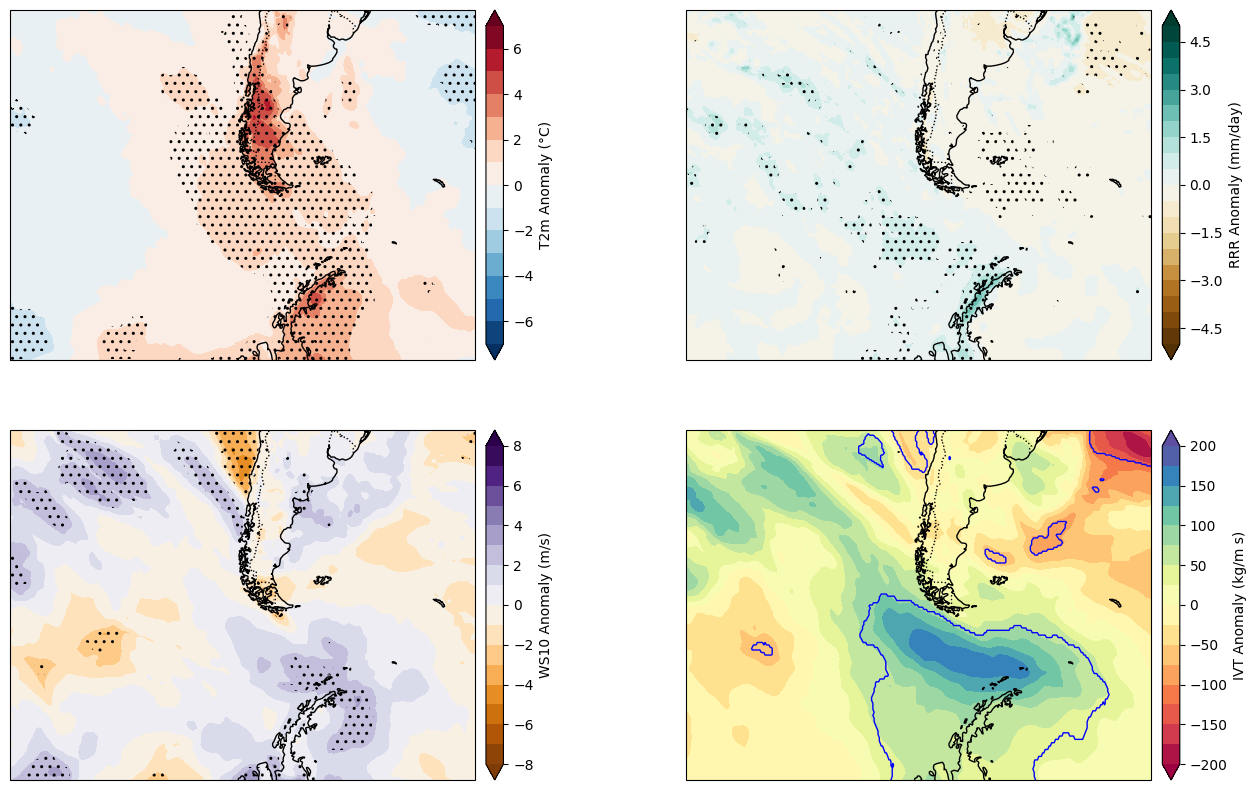

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), subplot_kw={'projection': proj})
axs = axs.flatten()
# --- Create figure and axes with Mercator projection ---
#fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})
ax = axs[0]
# --- Add geographic features ---
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Optional: Set geographical extent (adjust as needed)
ax.set_extent([-120, -30, -70, -30], crs=ccrs.PlateCarree())

# --- Plot T2m anomalies as shaded contours ---
levels_t2m = np.arange(-7, 8, 1)
cmap = plt.get_cmap("RdBu_r")
t2m_plot = ax.contourf(
    composite.longitude, composite.latitude, composite.t2m_anomaly,
    levels=levels_t2m,
    cmap=cmap,
    extend='both',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(t2m_plot, ax=ax, orientation='vertical', pad=0.02, label="T2m Anomaly (°C)")

ax.contourf(
    sig_mask.longitude, sig_mask.latitude, sig_mask.t2m_anomaly,
    levels=[0.5, 1],   # somente valores True (significativo)
    colors='none',
    hatches=['..'],  # pontilhado
    transform=ccrs.PlateCarree()
)

ax = axs[1]
# --- Add features ---
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# --- Set extent ---
ax.set_extent([-120, -30, -70, -30], crs=ccrs.PlateCarree())

# --- Plot precipitation (mm) ---
levels_precip = np.arange(-5, 5.5, 0.5)
cmap_precip = plt.get_cmap("BrBG")
precip_plot = ax.contourf(
    composite_rrr.longitude, composite_rrr.latitude, composite_rrr.tp_anomaly,  # Convert from m to mm
    levels=levels_precip,
    cmap=cmap_precip,
    extend='both',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(precip_plot, ax=ax, orientation='vertical', pad=0.02, label="RRR Anomaly (mm/day)")

ax.contourf(
    sig_mask_rrr.longitude, sig_mask_rrr.latitude, sig_mask_rrr.tp_anomaly,
    levels=[0.5, 1],   # somente valores True (significativo)
    colors='none',
    hatches=['..'],  # pontilhado
    transform=ccrs.PlateCarree()
)

ax = axs[2]

# --- Create figure and axes ---
#fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})

# --- Add geographic features ---
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Optional: set geographical extent
ax.set_extent([-120, -30, -70, -30], crs=ccrs.PlateCarree())

# --- Plot wind speed as color fill ---
levels_ws = np.arange(-8, 9, 1)
cmap_ws = plt.get_cmap("PuOr")
ws_plot = ax.contourf(
    composite_ws10.longitude, composite_ws10.latitude, composite_ws10.ws10_anomaly,
    levels=levels_ws,
    cmap=cmap_ws,
    extend='both',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(ws_plot, ax=ax, orientation='vertical', pad=0.02, label="WS10 Anomaly (m/s)")

ax.contourf(
    sig_mask_ws10.longitude, sig_mask_ws10.latitude, sig_mask_ws10.ws10_anomaly,
    levels=[0.5, 1],   # somente valores True (significativo)
    colors='none',
    hatches=['..'],  # pontilhado
    transform=ccrs.PlateCarree()
)

ax = axs[3]
# --- Add features ---
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# --- Set extent ---
ax.set_extent([-120, -30, -70, -30], crs=ccrs.PlateCarree())

# --- Plot precipitation (mm) ---
levels_precip = np.arange(-200, 201, 25)
cmap_precip = plt.get_cmap("Spectral")
precip_plot = ax.contourf(
    composite_ivt.longitude, composite_ivt.latitude, composite_ivt.ivt_anomaly,  # Convert from m to mm
    levels=levels_precip,
    cmap=cmap_precip,
    extend='both',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(precip_plot, ax=ax, orientation='vertical', pad=0.02, label="IVT Anomaly (kg/m s)")

ax.contour(
    sig_mask_ivt.longitude, sig_mask_ivt.latitude, sig_mask_ivt.ivt_anomaly, levels=[0.5],
    colors='blue', linewidths=1 ,  transform=ccrs.PlateCarree()
)
